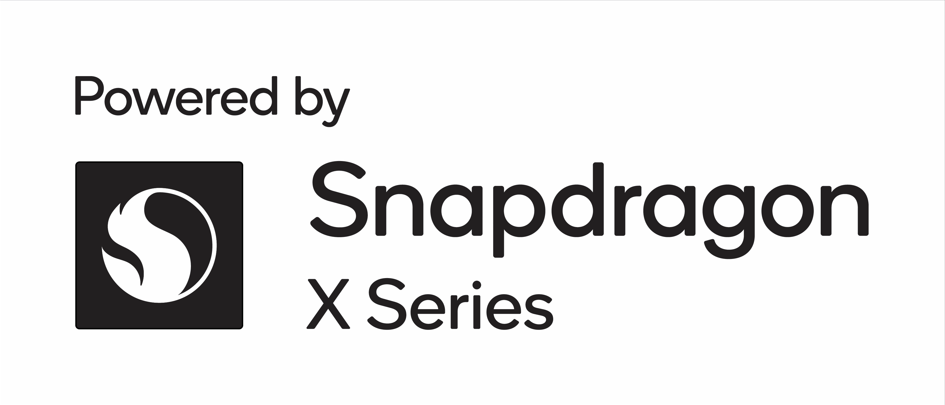

In [1]:
import platform

arch = platform.machine()
sys = platform.system()
processor = platform.processor()
print(f"{arch}\n{sys}\n{processor}")

ARM64
Windows
ARMv8 (64-bit) Family 8 Model 1 Revision 201, Qualcomm Technologies Inc


In [2]:
import onnxruntime as ort
import os
import numpy as np
import time
import gc
import psutil

from pathlib import Path
from tokenizers import Tokenizer

In [3]:
root_dir = Path.cwd().parent.parent
onnx_root = Path(ort.__file__).parent

In [4]:
# Subdirectory where all .onnx dependencies are located
model_subdirectory = "gemma-3-1b-it-ONNX-GQA"

# The embeddings model is entry point, use netron to visualize
model_name = "model.onnx"#_202506251838.onnx"

# Tokenizer
tokenizer_json = "tokenizer.json"

In [5]:
model_path = root_dir/"models"/model_subdirectory/model_name
# ctx_path = root_dir/"models"/model_subdirectory/context_model
# ctx_path_itr = root_dir/"models"/model_subdirectory/context_model_iter
# head_path = root_dir/"models"/model_subdirectory/head_model
tokenizer_path = root_dir/"models"/model_subdirectory/tokenizer_json
hexagon_driver = onnx_root/"capi"/"QnnHtp.dll"
# hexagon_driver = Path("C:/Users/DFS/.vscode/extensions/ms-windows-ai-studio.windows-ai-studio-0.14.4-win32-arm64/bin")/"QnnHtp.dll"

In [6]:
model_path

WindowsPath('C:/Users/DFS/Desktop/gitrepo/qnn_sample_apps/models/gemma-3-1b-it-ONNX-GQA/model.onnx')

In [7]:
# hexagon_driver

In [8]:
model_path.is_file()

True

In [ ]:
# hexagon_driver.is_file()

In [10]:
session_options = ort.SessionOptions()
session_options.log_severity_level = 0 

# Creating an inference session for the embedding graph
model_session = ort.InferenceSession(model_path,
                                # providers= [("QNNExecutionProvider",qnn_provider_options)],
                               sess_options= session_options
                              )
                           

model_session.get_providers()

['CPUExecutionProvider']

In [11]:
inputs = model_session.get_inputs()
outputs = model_session.get_outputs()

In [12]:
for layer in inputs:
    print(f"Name: {layer.name}\n\tExpected Input Shape: {layer.shape}\n\tExpected Input Type: {layer.type}")
    print("*"*100)

Name: input_ids
	Expected Input Shape: ['batch_size', 'sequence_length']
	Expected Input Type: tensor(int64)
****************************************************************************************************
Name: attention_mask
	Expected Input Shape: ['batch_size', 'total_sequence_length']
	Expected Input Type: tensor(int64)
****************************************************************************************************
Name: position_ids
	Expected Input Shape: ['batch_size', 'sequence_length']
	Expected Input Type: tensor(int64)
****************************************************************************************************
Name: past_key_values.0.key
	Expected Input Shape: ['batch_size', 1, 'past_sequence_length', 256]
	Expected Input Type: tensor(float)
****************************************************************************************************
Name: past_key_values.0.value
	Expected Input Shape: ['batch_size', 1, 'past_sequence_length', 256]
	Expected Input Type:

In [13]:
# Load in tokenizer using tokenizer path above
tokenizer = Tokenizer.from_file(str(tokenizer_path))

In [14]:
init_query = "<start_of_turn>user\nYou are a professional programmer. Give me ways to ensure that I win a coding Hackathon<end_of_turn><start_of_turn>model"
init_query

'<start_of_turn>user\nYou are a professional programmer. Give me ways to ensure that I win a coding Hackathon<end_of_turn><start_of_turn>model'

In [15]:
encoding = tokenizer.encode(init_query)
encoding

Encoding(num_tokens=25, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])

In [16]:
print("Token IDs:", encoding.ids)
print("Tokens:", encoding.tokens)

Token IDs: [2, 105, 2364, 107, 3048, 659, 496, 5707, 71123, 236761, 23097, 786, 4861, 531, 5330, 600, 564, 3345, 496, 20446, 43346, 26727, 106, 105, 4368]
Tokens: ['<bos>', '<start_of_turn>', 'user', '\n', 'You', '▁are', '▁a', '▁professional', '▁programmer', '.', '▁Give', '▁me', '▁ways', '▁to', '▁ensure', '▁that', '▁I', '▁win', '▁a', '▁coding', '▁Hack', 'athon', '<end_of_turn>', '<start_of_turn>', 'model']


In [17]:
input_ids = encoding.ids
input_ids

[2,
 105,
 2364,
 107,
 3048,
 659,
 496,
 5707,
 71123,
 236761,
 23097,
 786,
 4861,
 531,
 5330,
 600,
 564,
 3345,
 496,
 20446,
 43346,
 26727,
 106,
 105,
 4368]

In [18]:
len(input_ids)

25

In [19]:
batch_size = 1
num_kv_heads = 1
past_seq_length = len(input_ids)
attn_head_size = 256
num_layers = 26

In [20]:
empty_kv = {}
for i in range(num_layers):
    # Shape of key and value tensors for each transformer layer
    past_shape = (batch_size, num_kv_heads, past_seq_length, attn_head_size)

    # Initialize past keys for layer i (used in attention mechanism to avoid recomputation
    empty_kv[f"past_key_values.{i}.key"] = np.zeros(past_shape, dtype=np.float32)

    # Initialize past values for layer i
    empty_kv[f"past_key_values.{i}.value"] = np.zeros(past_shape, dtype=np.float32)

len(empty_kv)

52

In [21]:
empty_kv.keys()

dict_keys(['past_key_values.0.key', 'past_key_values.0.value', 'past_key_values.1.key', 'past_key_values.1.value', 'past_key_values.2.key', 'past_key_values.2.value', 'past_key_values.3.key', 'past_key_values.3.value', 'past_key_values.4.key', 'past_key_values.4.value', 'past_key_values.5.key', 'past_key_values.5.value', 'past_key_values.6.key', 'past_key_values.6.value', 'past_key_values.7.key', 'past_key_values.7.value', 'past_key_values.8.key', 'past_key_values.8.value', 'past_key_values.9.key', 'past_key_values.9.value', 'past_key_values.10.key', 'past_key_values.10.value', 'past_key_values.11.key', 'past_key_values.11.value', 'past_key_values.12.key', 'past_key_values.12.value', 'past_key_values.13.key', 'past_key_values.13.value', 'past_key_values.14.key', 'past_key_values.14.value', 'past_key_values.15.key', 'past_key_values.15.value', 'past_key_values.16.key', 'past_key_values.16.value', 'past_key_values.17.key', 'past_key_values.17.value', 'past_key_values.18.key', 'past_key_v

In [22]:
past_seq_length

25

In [23]:
# Setup attention mask
attention_mask = np.ones((batch_size, past_seq_length), dtype=np.int64)
attention_mask.shape
# Setup position ids

(1, 25)

In [24]:
input_ids = np.array([input_ids], dtype=np.int64)
input_ids.shape

(1, 25)

In [25]:
position_ids = np.arange(past_seq_length, dtype=np.int64).reshape(1, -1)
position_ids.shape

(1, 25)

In [26]:
position_ids

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19, 20, 21, 22, 23, 24]], dtype=int64)

In [27]:
attention_mask

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1]], dtype=int64)

In [33]:
input_dict = {
    "input_ids": input_ids,
    "attention_mask": attention_mask,
    "position_ids": position_ids,
    **empty_kv
}

In [34]:
input_dict

{'input_ids': array([[     2,    105,   2364,    107,   3048,    659,    496,   5707,
          71123, 236761,  23097,    786,   4861,    531,   5330,    600,
            564,   3345,    496,  20446,  43346,  26727,    106,    105,
           4368]], dtype=int64),
 'attention_mask': array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1]], dtype=int64),
 'position_ids': array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
         16, 17, 18, 19, 20, 21, 22, 23, 24]], dtype=int64),
 'past_key_values.0.key': array([[[[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]]]], dtype=float32),
 'past_key_values.0.value': array([[[[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
   

In [35]:
session_output = model_session.run(None, input_dict)
print("(batch, sequence length, vocab size)")
session_output[0].shape

(batch, sequence length, vocab size)


(1, 25, 262144)

In [36]:
print("(batch, num_key_value_heads, sequence_length, head_dim)")
session_output[1].shape

(batch, num_key_value_heads, sequence_length, head_dim)


(1, 1, 25, 256)

In [ ]:
# for layer in outputs:
#     print(f"Name: {layer.name}\n\tExpected Input Shape: {layer.shape}\n\tExpected Input Type: {layer.type}")
#     print("*"*100)

In [37]:
for layer in model_session.get_outputs():
    print(f"Name: {layer.name}")
    print(f"Shape: {layer.shape}")
    print(f"Type: {layer.type}")
    print("*"*100)

Name: logits
Shape: ['batch_size', 'sequence_length', 262144]
Type: tensor(float)
****************************************************************************************************
Name: present.0.key
Shape: ['batch_size', 1, 'total_sequence_length', 256]
Type: tensor(float)
****************************************************************************************************
Name: present.0.value
Shape: ['batch_size', 1, 'total_sequence_length', 256]
Type: tensor(float)
****************************************************************************************************
Name: present.1.key
Shape: ['batch_size', 1, 'total_sequence_length', 256]
Type: tensor(float)
****************************************************************************************************
Name: present.1.value
Shape: ['batch_size', 1, 'total_sequence_length', 256]
Type: tensor(float)
****************************************************************************************************
Name: present.2.key
Shape: ['

In [38]:
# Number of input sequences processed simultaneously
batch_size = 1

# Current sequence length for initial prompt (number of tokens in current sequence)
# seq_len = embedding_output.shape[1]

# Dimensionality of each token embedding vector
hidden_size = 1152

# Number of attention heads in each transformer layer
num_heads = 4

# Size of each attention head (should be hidden_size // num_heads
attn_head_size = 256 

# Total number of transformer layers
num_layers = 26

# SWA
max_seq_len = 512

# Number of key/value heads (key/value heads are shared amongst attention heads)
num_key_value_heads = 1

In [39]:
print("Logits:\n(batch, sequence length, vocab size)")
session_output[0].shape

Logits:
(batch, sequence length, vocab size)


(1, 25, 262144)

In [40]:
print("Batch, key/value heads, prompt length, head dimension (size of projection for each head)")
session_output[1].shape

Batch, key/value heads, prompt length, head dimension (size of projection for each head)


(1, 1, 25, 256)

In [41]:
# Update kv cache
present_kv = {f"past_key_values.{i}.key": session_output[1 + i * 2] for i in range(num_layers)}
present_kv.update({f"past_key_values.{i}.value": session_output[1 + i * 2 + 1] for i in range(num_layers)})
present_kv

{'past_key_values.0.key': array([[[[-0.00549414, -0.010484  ,  0.00624222, ...,  1.2165153 ,
            1.5235579 ,  0.8387669 ],
          [ 0.994539  ,  2.2174027 ,  0.4639257 , ...,  1.5638733 ,
            1.2549527 ,  1.1015066 ],
          [-1.9425399 ,  0.557605  ,  1.6409653 , ...,  1.2272222 ,
            0.46048498,  1.3053843 ],
          ...,
          [-1.8400192 ,  1.6101983 , -1.0469742 , ...,  0.23418261,
            1.7429215 ,  0.7945872 ],
          [-0.97485304, -0.41261548,  0.68224335, ...,  1.5628649 ,
            1.251154  ,  1.1022866 ],
          [ 1.3101816 , -1.7412348 ,  2.7200441 , ...,  1.4724233 ,
           -0.00656763,  0.4869218 ]]]], dtype=float32),
 'past_key_values.1.key': array([[[[ 4.5411475e-03,  9.8370276e-03, -2.8425851e-03, ...,
           -3.0300477e+00, -9.2506399e+00,  2.8986146e+00],
          [-3.1839028e-01, -8.1686705e-01,  8.4288621e-01, ...,
           -2.1896241e+00, -2.1271794e+00,  2.9221361e+00],
          [-5.6080514e-01,  9.11

In [42]:
present_kv.keys()

dict_keys(['past_key_values.0.key', 'past_key_values.1.key', 'past_key_values.2.key', 'past_key_values.3.key', 'past_key_values.4.key', 'past_key_values.5.key', 'past_key_values.6.key', 'past_key_values.7.key', 'past_key_values.8.key', 'past_key_values.9.key', 'past_key_values.10.key', 'past_key_values.11.key', 'past_key_values.12.key', 'past_key_values.13.key', 'past_key_values.14.key', 'past_key_values.15.key', 'past_key_values.16.key', 'past_key_values.17.key', 'past_key_values.18.key', 'past_key_values.19.key', 'past_key_values.20.key', 'past_key_values.21.key', 'past_key_values.22.key', 'past_key_values.23.key', 'past_key_values.24.key', 'past_key_values.25.key', 'past_key_values.0.value', 'past_key_values.1.value', 'past_key_values.2.value', 'past_key_values.3.value', 'past_key_values.4.value', 'past_key_values.5.value', 'past_key_values.6.value', 'past_key_values.7.value', 'past_key_values.8.value', 'past_key_values.9.value', 'past_key_values.10.value', 'past_key_values.11.value

In [43]:
# Dimension checks
present_kv["past_key_values.0.key"].shape

(1, 1, 25, 256)

In [44]:
logits = session_output[0]
logits.shape

(1, 25, 262144)

In [45]:
def softmax_numpy(x: np.array, temperature: float=1) -> np.array:
    # stabilize x in case of large numbers 
    x = x - np.max(x, axis=-1, keepdims=True)

    # Apply temperature
    x = x/temperature

    # Apply Softmax
    return np.exp(x)/np.sum(np.exp(x), axis=-1, keepdims=True)

def top_k_probas(probas: np.array, k: int=5) -> np.array:
    # Copy probas so in-place operations don't work on original variable
    probas = probas.copy()
    # Normalize probabilities
    probas /= np.sum(probas)
    # Using -probas to get in descending order
    top_indices_sorted = np.argsort(-probas)[:k]
    top_k_probas = probas[top_indices_sorted]

    # Renormalize top-k probabilites to sum to 1 (probabilites must sum to 1 to use np.random.choice
    top_k_probas /= np.sum(top_k_probas)

    # Return top k probabilities
    return top_indices_sorted, top_k_probas

def apply_repetition_penalty(logits, generated_ids, penalty=1.1):
    for token_id in set(generated_ids):
        logits[token_id] /= penalty
    return logits

In [46]:
softmax = lambda x, temperature=1: np.exp((x-np.max(x, axis=-1, keepdims=True))/temperature)/np.sum(np.exp((x-np.max(x, axis=-1, keepdims=True))/temperature), axis=-1, keepdims=True)

In [47]:
# Grabs last tokens logits
temp = 0.6
probas = softmax(logits[0,-1], temperature=temp)
# probas = probas / probas.sum()
next_token_id = int(np.random.choice(len(probas), p=probas)) #int(np.argmax(probas))
next_token_id

1374

In [48]:
input_ids.shape

(1, 25)

In [49]:
position_ids

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19, 20, 21, 22, 23, 24]], dtype=int64)

In [50]:
np.array([[input_ids.shape[-1]+1]], dtype=np.int64)

array([[26]], dtype=int64)

In [51]:
position_ids.shape

(1, 25)

In [52]:
tokenizer.decode([next_token_id])

' should'

In [53]:
temp = 0.3
start = time.time()
max_tokens = 500
top_k = 20
generated_ids = [next_token_id]
prev_seq_len = logits.shape[1]
printed_length = 0
# This is the next position (131)
position_itr = input_ids.shape[-1]
# position_ids = np.array((batch_size, 1), dtype=np.int64)
# print(prev_seq_len)
# print(attention_mask.shape)
print("\nInitial Query:\n", init_query)
print("Generated:")
for _ in range(max_tokens):
    input_ids = np.array([[next_token_id]], dtype=np.int64)
    position_ids = np.array([[position_itr]], dtype=np.int64)
    # print(tokenizer.decode(generated_ids, skip_special_tokens=True))
    # print(tokenizer.decode([next_token_id], skip_special_tokens=False),end=" ")
    iter_inputs = {
    "input_ids": input_ids,
    "attention_mask": attention_mask,
    "position_ids": position_ids,
    **present_kv,
    }

    session_output = model_session.run(None, iter_inputs)
    prev_seq_len += 1
    
    # Update attention mask
    attention_mask = np.ones((batch_size, prev_seq_len), dtype=np.int64)
    
    # Update position id
    position_itr += 1
    
    # Update KV Cache
    present_kv = {f"past_key_values.{i}.key": session_output[1 + i * 2] for i in range(num_layers)}
    present_kv.update({f"past_key_values.{i}.value": session_output[1 + i * 2 + 1] for i in range(num_layers)})
    # print(prev_seq_len)
    # print(present_kv.get("past_key_values.0.key").shape)
    # print(len(attention_mask))
    logits = session_output[0]

    token_logits = logits[0,-1]
    token_logits = apply_repetition_penalty(token_logits, generated_ids, penalty=1.1)
#     # Get probabilities
    probas = softmax(token_logits, temperature=temp)
    top_indices, top_probas = top_k_probas(probas, k=top_k) 
    next_token_id = int(np.random.choice(top_indices, p=top_probas)) #int(np.argmax(probas))
    generated_ids.append(next_token_id)
    
    full_text = tokenizer.decode(generated_ids, skip_special_tokens=True)
    new_text = full_text[printed_length:]
    if new_text:
        print(new_text, end="", flush=True)
        printed_length = len(full_text)

    if next_token_id == tokenizer.token_to_id("[/INST]"):
        break
end = time.time()
elapsed = end - start
tps = np.round((max_tokens / elapsed), 2)
print(f"\nTokens Per Second: {tps}")
output_text = tokenizer.decode(generated_ids, skip_special_tokens=True)



Initial Query:
 <start_of_turn>user
You are a professional programmer. Give me ways to ensure that I win a coding Hackathon<end_of_turn><start_of_turn>model
Generated:
 should you be a professional programmer.

Okay, let's dive into how to increase your chances of winning a coding hackathon! Here’s a breakdown of strategies, broken down into categories with actionable advice:

**I. Understanding the Challenge & Planning (Crucial - 20% of effort)**

* **1. Deep Dive into the Problem:** Don't just skim the brief.  Read it *multiple times*. Understand the core problem statement, the desired outcome, and any constraints. Ask clarifying questions if anything is unclear.
    * **Actionable Tip:** Take notes on key requirements, edge cases, and potential pitfalls.
* **2. Analyze Existing Solutions (if available):** Look at previous submissions. What approaches have been tried? Where are the gaps? This isn’t about copying; it’s about understanding the landscape.
    * **Actionable Tip:** Use 

In [ ]:
print(output_text)